In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, ttest_rel, ttest_1samp
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import trompy as tp

In [2]:
DATAFOLDER = Path("..\\data")
FIGSFOLDER = Path("..\\figures")
FIGSFOLDER = Path("C:\\Users\\jmc010\\Dropbox\\Publications in Progress\\IPP Giulia paper\\figs")

save_figs = True

def tweak_df(df):

    return (df
            .query("session == 's4'")
            )

df = pd.read_excel(DATAFOLDER / "metafile_ipp.xlsx", sheet_name="metafile Exp 1")
df = tweak_df(df)

In [3]:
def get_lickdata(row):
    filename = row.medfile
    
    L_on, L_off = tp.medfilereader(DATAFOLDER / filename, vars_to_extract=["b", "c"], remove_var_header=True)
    R_on, R_off = tp.medfilereader(DATAFOLDER / filename, vars_to_extract=["e", "f"], remove_var_header=True)
    
    L_lickdata = tp.lickCalc(L_on, offset=L_off)
    R_lickdata = tp.lickCalc(R_on, offset=R_off)

    if "cas" in row.bottleL and "malt" in row.bottleR:
        cas_lickdata, malt_lickdata = L_lickdata, R_lickdata
    elif "cas" in row.bottleR and "malt" in row.bottleL:
        cas_lickdata, malt_lickdata = R_lickdata, L_lickdata
    else:
        raise ValueError("Bottles not found")
    return cas_lickdata, malt_lickdata

row = df.loc[48,:]
cas_lickdata, malt_lickdata = get_lickdata(row)
# print(cas_lickdata, malt_lickdata)

In [4]:
def get_intake_per_solution(row):

    if "cas" in row.bottleL and "malt" in row.bottleR:
        return row.intakeL, row.intakeR
    elif "cas" in row.bottleR and "malt" in row.bottleL:
        return row.intakeR, row.intakeL
    else:
        raise ValueError("Bottles not found")
    
PR_cas, PR_malt = [], []
for row in df.query("dietgroup == 'PR'").iterrows():
    cas_ml, malt_ml = get_intake_per_solution(row[1])

    PR_cas.append(cas_ml)
    PR_malt.append(malt_ml)

NR_cas, NR_malt = [], []
for row in df.dropna().query("dietgroup == 'NR'").iterrows():
    cas_ml, malt_ml = get_intake_per_solution(row[1])

    NR_cas.append(cas_ml)
    NR_malt.append(malt_ml)

NR_cas, NR_malt = zip(*[(c, m) for c, m in zip(NR_cas, NR_malt) if c > 0 and m > 0])
PR_cas, PR_malt = zip(*[(c, m) for c, m in zip(PR_cas, PR_malt) if c > 0 and m > 0])

NR_cas = np.array(NR_cas)
NR_malt = np.array(NR_malt)
PR_cas = np.array(PR_cas)
PR_malt = np.array(PR_malt)

## Panel S1A

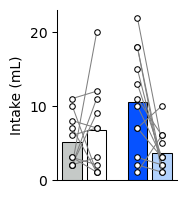

In [5]:
colors = ["xkcd:silver", "white", "xkcd:electric blue", "xkcd:powder blue"]

f, ax = plt.subplots(figsize=(2, 2),
                     gridspec_kw={"left": 0.35, "bottom": 0.1, "top": 0.95, "right": 0.95})

tp.barscatter([[NR_cas, NR_malt], [PR_cas, PR_malt],],
              ax=ax,
              paired=True,
              barfacecolor_option="individual",
              barfacecolor=colors,
              scattersize=40
            );

ax.set_yticks([0, 10, 20])
ax.set_ylabel("Intake (mL)")

if save_figs:
    f.savefig(FIGSFOLDER / "S1A_mL_per_solution.pdf", dpi=300)

In [6]:
### Stats
data = {
    'subject': np.tile(np.arange(1, len(NR_cas) + len(PR_cas) + 1), 2),
    'diet': np.tile(["NR"] * len(NR_cas) + ["PR"] * len(PR_cas), 2),
    'solution': np.array(["cas"] * (len(NR_cas) + len(PR_cas)) + ["malt"] * (len(NR_malt) + len(PR_malt))),
    'licks': np.concatenate([NR_cas, PR_cas, NR_malt, PR_malt])
}

df_stats = pd.DataFrame(data)

aov = pg.mixed_anova(data=df_stats, dv='licks', subject='subject', within='solution', between='diet')

print(aov)

        Source          SS  DF1  DF2          MS         F     p-unc  \
0         diet   16.969862    1   21   16.969862  0.758320  0.393701   
1     solution   91.847826    1   21   91.847826  3.200108  0.088069   
2  Interaction  209.921113    1   21  209.921113  7.313948  0.013279   

        np2  eps  
0  0.034852  NaN  
1  0.132235  1.0  
2  0.258316  NaN  


In [7]:
## Posthocs
ncomps = 4 #because NR vs PR for each solution and cas vs malt for each diet group

# solution
_, p = ttest_rel(NR_cas, NR_malt)
print("NR cas vs NR malt = {:.3f} ({:.3f} before correction))".format(tp.sidakcorr(p, ncomps=ncomps), p))

_, p = ttest_rel(PR_cas, PR_malt)
print("PR cas vs PR malt = {:.3f} ({:.3f} before correction))".format(tp.sidakcorr(p, ncomps=ncomps), p))

# diet
_, p = ttest_ind(NR_cas, PR_cas)
print("NR cas vs PR cas = {:.3f} ({:.3f} before correction))".format(tp.sidakcorr(p, ncomps=ncomps), p))

_, p = ttest_ind(NR_malt, PR_malt)
print("NR malt vs PR malt = {:.3f} ({:.3f} before correction))".format(tp.sidakcorr(p, ncomps=ncomps), p))

NR cas vs NR malt = 0.928 (0.481 before correction))
PR cas vs PR malt = 0.039 (0.010 before correction))
NR cas vs PR cas = 0.100 (0.026 before correction))
NR malt vs PR malt = 0.410 (0.124 before correction))


In [12]:
print("NR rats drink average of {:.2f} mL or {:.2f} g protein".format(np.mean(NR_cas), np.mean(NR_cas) * 0.04))
print("PR rats drink average of {:.2f} mL or {:.2f} g protein".format(np.mean(PR_cas), np.mean(PR_cas) * 0.04))

NR rats drink average of 5.09 mL or 0.20 g protein
PR rats drink average of 10.58 mL or 0.42 g protein


## Panel S1B

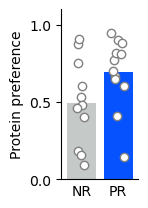

In [13]:
np.random.seed(41)

def jitter(x, n, spread=0.1):
    return x + np.random.normal(0, spread, n)

def calc_pref(cas, malt):
    if malt == 0:
        return 1
    elif cas == 0:
        return 0
    else:
        return cas / (cas + malt)

PR_pref = np.array([calc_pref(cas, malt) for cas, malt in zip(PR_cas, PR_malt)])
NR_pref = np.array([calc_pref(cas, malt) for cas, malt in zip(NR_cas, NR_malt)])

f, ax = plt.subplots(figsize=(1.4, 2),
                     gridspec_kw={"left": 0.4, "bottom": 0.1, "top": 0.95, "right": 0.95})

ax.bar( 0, np.mean(NR_pref), color=colors[0])
ax.bar( 1, np.mean(PR_pref), color=colors[2])

ax.scatter(jitter(0, len(NR_pref)), NR_pref, color="white", edgecolor="grey")
ax.scatter(jitter(1, len(PR_pref)), PR_pref, color="white", edgecolor="grey")

ax.set_ylim(0, 1.1)
ax.set_xlim(-0.55, 1.55)
ax.set_yticks([0, 0.5, 1])

ax.set_xticks([0, 1], labels=["NR", "PR"])

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.tick_params(axis='x', which='both', length=0)

ax.set_ylabel("Protein preference")

if save_figs:
    f.savefig(FIGSFOLDER / "S1B_preference_mL.pdf", dpi=300)

In [14]:
## Statistics
t, p = ttest_1samp(NR_pref, 0.5)
print("NR preference: t={:.3f}, p={:.3f}".format(t, p))

t, p = ttest_1samp(PR_pref, 0.5)
print("PR preference: t={:.3f}, p={:.3f}".format(t, p))

NR preference: t=-0.071, p=0.944
PR preference: t=2.906, p=0.014


## Panel S1C and D

In [15]:
# to correlate licks with intake
cas_licks, cas_intake, malt_licks, malt_intake = [], [], [], []

for row in df.dropna().iterrows():
    cas_lickdata_, malt_lickdata_ = get_lickdata(row[1])
    cas_intake_, malt_intake_ = get_intake_per_solution(row[1])
    
    cas_licks.append(cas_lickdata_["total"])
    malt_licks.append(malt_lickdata_["total"])
    cas_intake.append(cas_intake_)
    malt_intake.append(malt_intake_)

cas_licks, cas_intake = zip(*[(cl, ci) for cl, ci in zip(cas_licks, cas_intake) if ci > 0])
malt_licks, malt_intake = zip(*[(ml, mi) for ml, mi in zip(malt_licks, malt_intake) if mi > 0])

cas_licks = np.array(cas_licks)
malt_licks = np.array(malt_licks)   
cas_intake = np.array(cas_intake)
malt_intake = np.array(malt_intake)

c:\Users\jmc010\AppData\Local\miniconda3\Lib\site-packages\trompy\lickcalc.py:239: RuntimeWarning: invalid value encountered in power
  return (np.exp(-(alpha*x)**beta))


250.21061137790906
224.45992939099742


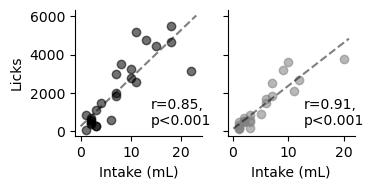

In [16]:
def make_corr_plot(x, y, ax=None, color="black", limit_range=False):

    if ax is None:
        f, ax = plt.subplots(figsize=(2, 2))
    
    ax.scatter(x, y, color=color, alpha=0.1)

    # to limit to the range of malt data
    if limit_range:
        x_ = x[y > 4000]
        y_ = y[y > 4000]
        x = x[y < 4000]
        y = y[y < 4000]

    ax.scatter(x, y, color=color, alpha=0.5)
    if limit_range:
        ax.scatter(x_, y_, facecolors='white', edgecolors='grey', alpha=0.1)

    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    x_vals = np.array(ax.get_xlim())
    regression_line = slope * x_vals + intercept

    ax.plot(x_vals, regression_line, color="black", alpha=0.5, linestyle="--")

    #ax.text(0.5, 0.2, f"{slope:.0f} licks/mL",
    #        transform=ax.transAxes, ha="left")
    
    ax.text(0.6, 0.3, f"r={r_value:.2f},\np<0.001",
            transform=ax.transAxes, ha="left", va="top")
    
    print(slope)

f, [ax1, ax2] = plt.subplots(ncols=2, sharey=True,
                     gridspec_kw={"wspace": 0.2, "bottom": 0.25, "left":0.2},
                     figsize=(4, 2)
                     )
                     
make_corr_plot(cas_intake, cas_licks, ax=ax1, color="black", limit_range=False)
make_corr_plot(malt_intake, malt_licks, ax=ax2, color="grey", limit_range=False)

for axis in [ax1, ax2]:
    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)
    axis.set_xticks([0, 10, 20])
    axis.set_yticks([0, 2000, 4000, 6000])
    axis.set_xlabel("Intake (mL)")

ax1.set_ylabel("Licks")

if save_figs:
    f.savefig(FIGSFOLDER / "S1C_licks_vs_intake.pdf", dpi=300)

## Panel S1E

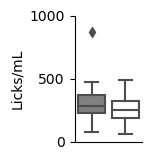

In [17]:
f, ax = plt.subplots(figsize=(1.5, 2),
                     gridspec_kw={"wspace": 0.2, "bottom": 0.25, "left":0.45})

sns.boxplot(data=[cas_licks / cas_intake, malt_licks / malt_intake], ax=ax, palette=["grey", "white"])

ax.set_ylabel("Licks/mL")
ax.set_yticks([0, 500, 1000])
ax.set_xticks([])

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

if save_figs:
    f.savefig(FIGSFOLDER / "S1D_licks_per_mL.pdf", dpi=300)

In [18]:
# Stats
print(np.nanmean(cas_licks / cas_intake))
print(np.nanmean(malt_licks / malt_intake))

ttest_ind(cas_licks / cas_intake, malt_licks / malt_intake)

295.87407969807975
255.8570079678775


TtestResult(statistic=1.0285602583463342, pvalue=0.30906457987381303, df=46.0)

## Panel S1F

In [19]:
cas_licklength, malt_licklength = [], []
for row in df.iterrows():
    cas_lickdata_, malt_lickdata_ = get_lickdata(row[1])
    
    cas_licklength.append(cas_lickdata_["licklength"])
    malt_licklength.append(malt_lickdata_["licklength"])

c:\Users\jmc010\AppData\Local\miniconda3\Lib\site-packages\trompy\lickcalc.py:239: RuntimeWarning: invalid value encountered in power
  return (np.exp(-(alpha*x)**beta))


0.9851111111111112
0.983086807111908


c:\Users\jmc010\AppData\Local\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jmc010\AppData\Local\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


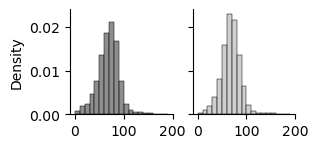

In [31]:
c_ = np.array(tp.flatten_list(cas_licklength)) * 1000
m_ = np.array(tp.flatten_list(malt_licklength)) * 1000

f, [ax1, ax2] = plt.subplots(ncols=2, sharey=True,
                     figsize=(3, 1.5),
                     gridspec_kw={"left": 0.2, "bottom": 0.25, "top": 0.95, "right": 0.95})

bins = np.arange(0, 200, 10)
sns.histplot(c_, bins=bins, color="dimgrey", ax=ax1, stat="density")
sns.histplot(m_, bins=bins, color="silver", ax=ax2, stat="density")

ax1.set_ylabel("Density")
ax1.set_yticks([0, 0.01, 0.02])

for ax in [ax1, ax2]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xticks([0, 100, 200])

if save_figs:
    f.savefig(FIGSFOLDER / "S1F_lick_length_hist.pdf", dpi=300)

print(np.sum(c_ < 200) / len(c_))
print(np.sum(m_ < 200) / len(m_))

c:\Users\jmc010\AppData\Local\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jmc010\AppData\Local\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


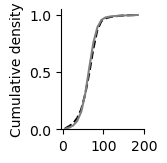

In [ ]:
f, ax = plt.subplots(figsize=(1.5, 1.5),
                     gridspec_kw={"left": 0.35, "bottom": 0.25, "top": 0.95, "right": 0.90})

sns.histplot(c_, bins=bins, color="black", ax=ax, linestyle="--",
             stat="density", cumulative=True, element="poly", linewidth=1.5, fill=False)

sns.histplot(m_, bins=bins, color="grey", ax=ax, linestyle="-",
             stat="density", cumulative=True, element="poly", linewidth=1.5, fill=False)

ax.set_ylabel("Cumulative density")
ax.set_yticks([0, 0.5, 1])
ax.set_xticks([0, 100, 200])

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

if save_figs:
    f.savefig(FIGSFOLDER / "S1G_lick_length_cdf.pdf", dpi=300)

TtestResult(statistic=0.6609355718886007, pvalue=0.5142541582354688, df=27)

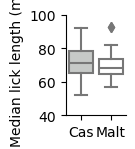

In [33]:
cas_med = np.array([np.median(c) for c in cas_licklength]) * 1000
malt_med = np.array([np.median(m) for m in malt_licklength]) * 1000

f, ax = plt.subplots(figsize=(1, 1.5),
                     gridspec_kw={"left": 0.35, "bottom": 0.25, "top": 0.92, "right": 0.95})

sns.boxplot(data=[cas_med, malt_med], ax=ax, palette=colors)

ax.set_yticks([40, 60, 80, 100])
ax.set_ylabel("Median lick length (ms)")
ax.set_xticks([0, 1], labels=["Cas", "Malt"])

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

if save_figs:
    f.savefig(FIGSFOLDER / "S1E_lick_length.pdf", dpi=300)

ttest_rel(cas_med, malt_med)

## Panel S1G

In [34]:
cas_ilis_, malt_ilis_ = [], []
for row in df.iterrows():
    cas_lickdata_, malt_lickdata_ = get_lickdata(row[1])
    
    cas_ilis_.append(cas_lickdata_["ilis"])
    malt_ilis_.append(malt_lickdata_["ilis"])

cas_ilis = np.array([ili for ili in tp.flatten_list(cas_ilis_) if ili < 0.3])*1000
malt_ilis = np.array([ili for ili in tp.flatten_list(malt_ilis_) if ili < 0.3])*1000

c:\Users\jmc010\AppData\Local\miniconda3\Lib\site-packages\trompy\lickcalc.py:239: RuntimeWarning: invalid value encountered in power
  return (np.exp(-(alpha*x)**beta))


c:\Users\jmc010\AppData\Local\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jmc010\AppData\Local\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


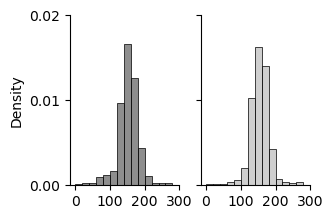

In [35]:
f, [ax1, ax2] = plt.subplots(ncols=2, sharey=True,
                     figsize=(4, 2),
                     gridspec_kw={"left": 0.35, "bottom": 0.1, "top": 0.95, "right": 0.95})

bins = np.arange(0, 300, 20)
sns.histplot(cas_ilis, bins=bins, color="dimgrey", ax=ax1, stat="density")
sns.histplot(malt_ilis, bins=bins, color="silver", ax=ax2, stat="density")

ax1.set_ylabel("Density")
ax1.set_yticks([0, 0.01, 0.02])

for ax in [ax1, ax2]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xticks([0, 100, 200, 300])

if save_figs:
    f.savefig(FIGSFOLDER / "S1F_frequency_hist.pdf", dpi=300)

In [36]:
len(cas_ilis_)

28

TtestResult(statistic=1.2607061259148007, pvalue=0.2182008003375665, df=27)

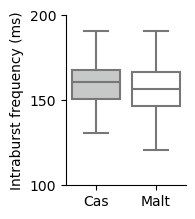

In [37]:
cas_med = np.array([np.median(c) for c in cas_ilis_]) * 1000
malt_med = np.array([np.median(m) for m in malt_ilis_]) * 1000

f, ax = plt.subplots(figsize=(2, 2),
                     gridspec_kw={"left": 0.35, "bottom": 0.1, "top": 0.95, "right": 0.95})

sns.boxplot(data=[cas_med, malt_med], ax=ax, palette=colors)

ax.set_yticks([100, 150, 200])
ax.set_ylabel("Intraburst frequency (ms)")
ax.set_xticks([0, 1], labels=["Cas", "Malt"])

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

if save_figs:
    f.savefig(FIGSFOLDER / "S1E_intraburst_freq.pdf", dpi=300)

ttest_rel(cas_med, malt_med)